In [240]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import csv

# Baseline Experiments Results Visualization

In [241]:
# get all the CSV files from the parent directory
csv_files = [f for f in os.listdir("..") if f.endswith(".csv") and f.startswith("llm_query_results")]

print(csv_files)

['llm_query_results--openrouter--simplePrompt--temp_0.2--top_p_0.1--openai-gpt-5-mini.csv']


In [242]:
# load each csv and concatenate them into a single dataframe

df = pd.DataFrame()

for f in csv_files:
    csv_df = pd.read_csv(os.path.join("..", f), quotechar='"', quoting=csv.QUOTE_NONNUMERIC)

    parts = f.split('--')
    provider = parts[1]
    temp = parts[3].split('_')[1]
    top_p = parts[4].split('_')[1]
    model_name = '--'.join(parts[5:]).replace('.csv', '')
    if 'openai' in model_name:
        model_name = model_name.replace('openai-', '')

    csv_df['source_file'] = f
    csv_df['provider'] = provider
    csv_df['generic_model_name'] = model_name

    df = pd.concat([df, csv_df], ignore_index=True)


In [243]:
print(df.columns)

print(f'DF Size: {df.shape}')

# print the df datatypes
print(df.dtypes)

print(df.error.value_counts( dropna=False ))

Index(['source_code', 'combined_name', 'kernel_name', 'exec_args', 'grid_size',
       'block_size', 'total_num_threads', 'empirical_sp_flop_count',
       'empirical_dp_flop_count', 'prompt_type', 'raw_flop_counts',
       'predicted_sp_flop_count', 'predicted_dp_flop_count',
       'predicted_sp_flop_count_explanation',
       'predicted_dp_flop_count_explanation', 'input_tokens', 'output_tokens',
       'total_cost', 'trial', 'modelName', 'nnz_flop_state', 'variant',
       'top_p', 'temp', 'totalQueryTime', 'error', 'source_file', 'provider',
       'generic_model_name'],
      dtype='object')
DF Size: (282, 29)
source_code                             object
combined_name                           object
kernel_name                             object
exec_args                               object
grid_size                               object
block_size                              object
total_num_threads                      float64
empirical_sp_flop_count                float64


## Adjust some of the columns

In [244]:
def parse_total_cost(x):
    if pd.isna(x):
        return -1.0
    cost_list = eval(x)
    assert len(cost_list) == 1, f"Expected a single cost value, got: {cost_list}"
    return cost_list[0]

df['total_cost'] = df['total_cost'].apply(parse_total_cost)
df['totalQueryTime'] = df['totalQueryTime'].astype(float)

def parse_error(x):
    if pd.isna(x):
        return "No Error"
    return str(x)

df['error'] = df['error'].apply(parse_error)
df['has_nz_flops'] = df['nnz_flop_state'].apply(lambda x: 'No' if x == 'Zero SP + DP FLOP' else 'Yes')

In [249]:
# now we want to plot the prediction accuracy vs. the ground truth for each generic_model_name and prompt_type

def plot_predictions_for_model_name(df, model_name='gpt-5-mini', prompt_type='simple'):
    success_df = df[(df['generic_model_name'] == model_name) & (df['error'] == 'No Error') & (df['prompt_type'] == prompt_type)]

    print(f'Success DF Size: {success_df.shape}')
    fig, ax = plt.subplots(1, 1, figsize=(5, 4), dpi=200)

    max_sp_dp_flop = max(
        success_df['empirical_sp_flop_count'].max(),
        success_df['empirical_dp_flop_count'].max(),
        success_df['predicted_sp_flop_count'].max(),
        success_df['predicted_dp_flop_count'].max()
    )
    min_sp_dp_flop = min(
        success_df['empirical_sp_flop_count'].min(),
        success_df['empirical_dp_flop_count'].min(),
        success_df['predicted_sp_flop_count'].min(),
        success_df['predicted_dp_flop_count'].min()
    )

    # plot the x-y line on the plot
    ax.plot([min_sp_dp_flop, max_sp_dp_flop], [min_sp_dp_flop, max_sp_dp_flop], color='red', linestyle='--', alpha=0.5, label='perfect prediction')

    sns.scatterplot(x='empirical_sp_flop_count', y='predicted_sp_flop_count', data=success_df, label='SP FLOP', alpha=0.5, ax=ax, color='orange')
    sns.scatterplot(x='empirical_dp_flop_count', y='predicted_dp_flop_count', data=success_df, label='DP FLOP', alpha=0.5, ax=ax, color='blue')

    ax.set_xscale('symlog')
    ax.set_yscale('symlog')

    ax.set_title(f'Baseline: LLM-Predicted vs Actual FLOP Counts \n({model_name} -- {prompt_type} prompt)')

    ax.set_xlabel('Actual/Profiled FLOP Count')
    ax.set_ylabel('LLM-Predicted FLOP Count')
    # change x ticks font size
    ax.tick_params(axis='x', labelsize=6)
    # adjust the legend font size to be smaller
    ax.legend(fontsize=6)

    # put the legend outside the plot
    ax.legend(bbox_to_anchor=(1.01, 0.65), loc='upper left', fontsize=6)

    plt.tight_layout()
    plt.show()


    # let's make histograms of the total_cost, totalQueryTime, and failure cases
    fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=200)

    sns.histplot(data=success_df, x='total_cost', hue='has_nz_flops', bins=50, ax=axs[0])
    axs[0].set_title('Query Cost Distribution')
    axs[0].set_xlabel('Query Cost ($ USD)')
    axs[0].set_ylabel('Frequency')
    axs[0].get_legend().set_title('Kernel has NZ FLOPs?')

    # rotate the x ticks for the query cost plot
    for label in axs[0].get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')


    sns.histplot(data=success_df, x='totalQueryTime', hue='has_nz_flops', bins=50, ax=axs[1])
    axs[1].set_title('Total Query Time Distribution')
    axs[1].set_xlabel('Total Query Time (seconds)')
    axs[1].set_ylabel('Frequency')
    axs[1].get_legend().set_title('Kernel has NZ FLOPs?')

    #error_value_counts = df['error'].value_counts()
    sns.countplot(data=df, x='error', ax=axs[2])
    axs[2].set_title('Failure Cases Distribution')
    axs[2].set_xlabel('Failure Cases')
    axs[2].set_ylabel('Frequency')

    # add countplot values on top of the bars
    for p in axs[2].patches:
        axs[2].annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=6, color='black', xytext=(0, 5), textcoords='offset points')

    plt.tight_layout()
    plt.show()

    return


Success DF Size: (273, 30)


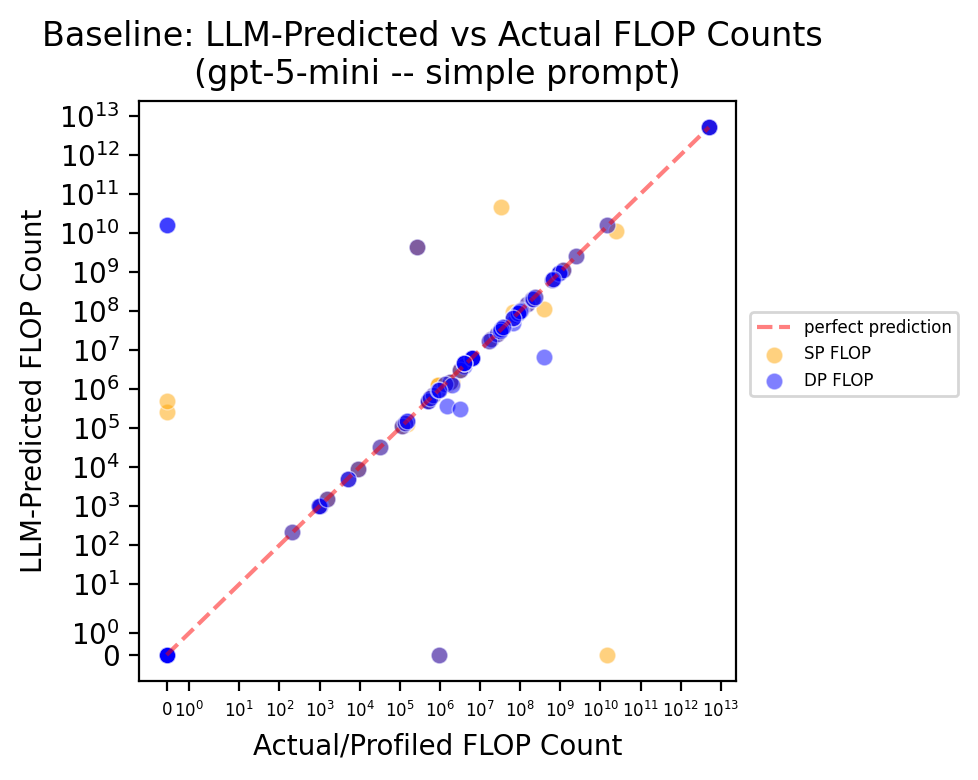

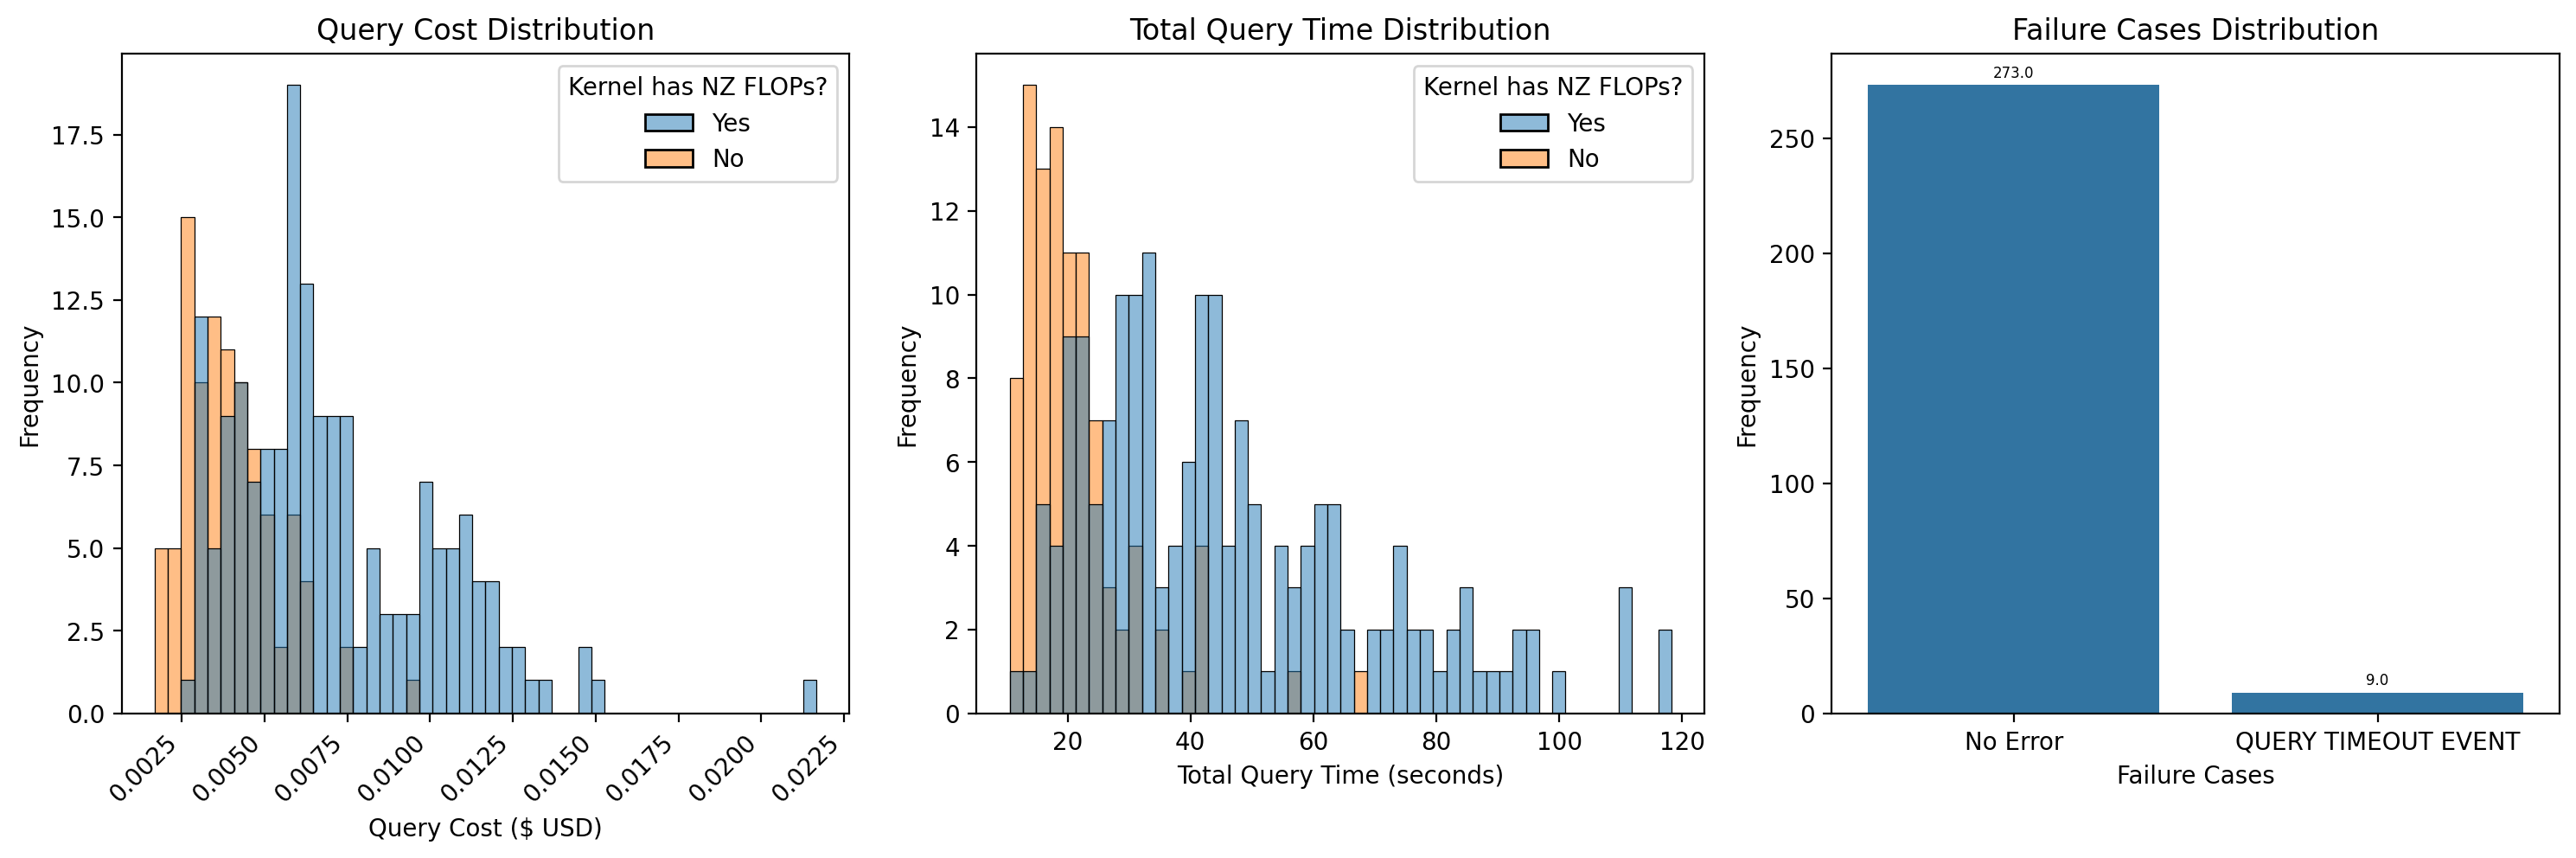

In [250]:
plot_predictions_for_model_name(df, 'gpt-5-mini', 'simple')